In [ ]:
import json
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Path to the JSON file produced by sample_attn_distrib.py
attn_path = Path("attn_samples.json")

# Load raw attention score samples
with attn_path.open("r", encoding="utf-8") as f:
    attn_data = json.load(f)

# Basic metadata from the file
model_name = attn_data.get("model_name", "")
layer_idx = attn_data.get("layer_idx", None)
head_idx = attn_data.get("head_idx", None)
seq_len = attn_data.get("seq_len", None)

print(f"Loaded samples from model: {model_name}")
print(f"Layer index: {layer_idx}, head index: {head_idx}, seq_len: {seq_len}")

# Convert scores to tensors and compute softmax weights
pos_entries = attn_data["positions"]

positions = []          # list[int]
scores_tensors = []     # list[torch.Tensor], each shape (num_keys,), q.k/sqrt(d_k)
logits_tensors = []      # list[torch.Tensor], each shape (num_keys,), e^scores
probs_tensors = []      # list[torch.Tensor], each shape (num_keys,), softmaxed scores

for entry in pos_entries:
    pos = int(entry["pos"])
    scores = torch.tensor(entry["scores_sorted"], dtype=torch.float32)

    logits = torch.exp(scores)

    # Softmax over the "sorted scores" dimension
    probs = torch.softmax(scores, dim=0)

    positions.append(pos)
    scores_tensors.append(scores)
    logits_tensors.append(logits)
    probs_tensors.append(probs)

print(f"Loaded {len(positions)} positions.")
print(f"Example position: {positions[44]}, num_keys = {scores_tensors[44].shape[0]}")

Loaded samples from model: Qwen/Qwen2.5-7B-Instruct
Layer index: 14, head index: 14, seq_len: 15911
Loaded 64 positions.
Example position: 9955, num_keys = 9956


Plotting samples at these indices (pos in sequence):
  idx=0, pos=170
  idx=9, pos=1648
  idx=18, pos=3646
  idx=27, pos=5578
  idx=36, pos=7591
  idx=45, pos=10540
  idx=54, pos=12213
  idx=63, pos=15746


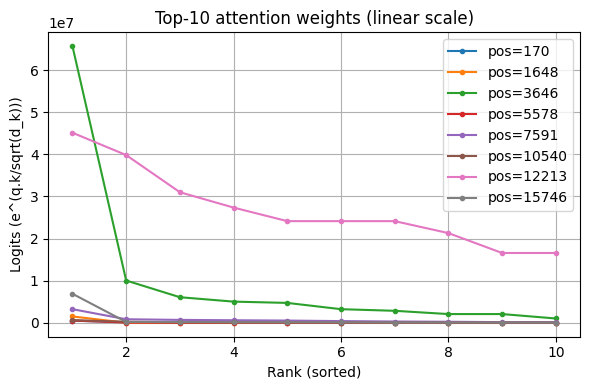

In [4]:
# How many samples to visualize
num_samples_to_plot = 8

num_available = len(positions)
if num_available == 0:
    raise ValueError("No positions loaded from attn_samples.json.")

# Pick a few (roughly) evenly spaced samples across the sequence
indices = np.linspace(0, num_available - 1, num_samples_to_plot, dtype=int)

print("Plotting samples at these indices (pos in sequence):")
for idx in indices:
    print(f"  idx={idx}, pos={positions[idx]}")

max_ranks_linear = 10  # you can tweak this

plt.figure(figsize=(6, 4))
for idx in indices:
    logits = logits_tensors[idx].cpu().numpy()
    ranks = np.arange(1, len(logits) + 1)

    # truncate to first max_ranks_linear
    r = ranks[:max_ranks_linear]
    p = logits[:max_ranks_linear]

    plt.plot(r, p, marker=".", linestyle="-", label=f"pos={positions[idx]}")

plt.xlabel("Rank (sorted)")
plt.ylabel("Logits (e^(q.k/sqrt(d_k)))")
plt.title(f"Top-{max_ranks_linear} attention weights (linear scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
import math
import numpy as np
import torch

def conservative_fit_k(
    head_logits: torch.Tensor,
    total_len: int,
    tau: float,
    tail_frac: float = 0.1,
) -> int:
    """
    Conservative-ish estimate of K using only the first H logits (unnormalized weights, e^{dot}).

    head_logits: sorted descending, shape (H,)
    total_len: total number of keys N for this position
    tau: target mass in (0,1)
    tail_frac: p in (0,1], we assume average tail weight = p * w_min instead of w_min.

    Model assumptions:
      - For i <= H, weights are exactly head_logits[i].
      - For i > H, average weight is tail_frac * w_min, where w_min = head_logits[H-1].
      - This is less pessimistic than tail = w_min, but still downward-biased
        compared to the true decaying tail (so K is still on the safe side if p is small enough).

    We enforce:
        sum_{i<=K} w_i / sum_{i<=total_len} w_i >= tau
    under this approximate model.
    """
    if not (0.0 < tau < 1.0):
        raise ValueError("tau must be in (0,1)")
    if not (0.0 < tail_frac <= 1.0):
        raise ValueError("tail_frac must be in (0,1].")

    H = head_logits.shape[0]
    if H == 0:
        return 0

    # Move to CPU float64 for stable sums
    w_head = head_logits.to(dtype=torch.float64, device="cpu")
    w_min = w_head[-1].item()

    # Sum of top-H
    S_H = w_head.sum().item()

    tail_len = max(total_len - H, 0)
    # Approximate tail mass
    tail_mass = tail_len * w_min * tail_frac

    # Total mass under this approximate model
    T = S_H + tail_mass
    target = tau * T

    # 1) Check if some K <= H is enough
    cumsum = torch.cumsum(w_head, dim=0).numpy()  # shape (H,)
    idx = np.searchsorted(cumsum, target)
    if idx < H:
        return int(idx + 1)

    # 2) Need K > H; each extra key contributes ~ w_min * tail_frac
    eff_min = w_min * tail_frac
    if eff_min <= 0.0:
        # Degenerate case: smallest head weight effectively zero
        return int(total_len)

    need = target - S_H
    if need <= 0.0:
        # Should not happen, but be defensive
        return int(H)

    K_cont = H + need / eff_min
    K = int(math.ceil(K_cont))
    K = max(H, min(K, total_len))
    return K


def true_k(full_logits: torch.Tensor, tau: float) -> int:
    """
    True minimal K using all logits (unnormalized weights, e^{dot}).

    We consider:
        w_i = logits[i]  (already >= 0)
        p_i = w_i / sum_j w_j

    We find the smallest K such that:
        sum_{i<=K} p_i >= tau
    which is equivalent to:
        sum_{i<=K} w_i >= tau * sum_j w_j

    Assumes full_logits is sorted in descending order.
    """
    if not (0.0 < tau < 1.0):
        raise ValueError("tau must be in (0,1)")

    w = full_logits.to(dtype=torch.float64, device="cpu")
    total = w.sum().item()
    if total <= 0.0:
        return w.shape[0]

    target = tau * total
    cumsum = torch.cumsum(w, dim=0).numpy()
    idx = np.searchsorted(cumsum, target)
    if idx >= w.shape[0]:
        return w.shape[0]
    return int(idx + 1)


# ----------------------------------------------------------------------
# Run over all positions and compare conservative vs true K
# ----------------------------------------------------------------------

tau = 0.9         # target mass
H = 128           # how many logits are visible in the conservative method
tail_frac = 0.05  # p, scaling factor for tail mass

k_true_list = []
k_cons_list = []
pos_list = []

for pos, logits in zip(positions, logits_tensors):
    w_full = logits  # shape (N,), sorted descending
    N = w_full.shape[0]

    # true K using full information
    K_true = true_k(w_full, tau)

    # conservative-ish K using only top-H (or fewer if N < H)
    H_eff = min(H, N)
    K_cons = conservative_fit_k(
        w_full[:H_eff],
        total_len=N,
        tau=tau,
        tail_frac=tail_frac,
    )

    print(f"pos={pos}: K_true={K_true}, K_cons={K_cons}")

pos=170: K_true=17, K_cons=17
pos=473: K_true=11, K_cons=11
pos=498: K_true=13, K_cons=13
pos=552: K_true=14, K_cons=11
pos=584: K_true=1, K_cons=1
pos=775: K_true=42, K_cons=39
pos=1488: K_true=96, K_cons=81
pos=1583: K_true=55, K_cons=56
pos=1599: K_true=12, K_cons=9
pos=1648: K_true=24, K_cons=22
pos=1738: K_true=47, K_cons=42
pos=1743: K_true=31, K_cons=28
pos=1888: K_true=82, K_cons=98
pos=2350: K_true=45, K_cons=50
pos=2611: K_true=92, K_cons=81
pos=2679: K_true=42, K_cons=48
pos=3321: K_true=106, K_cons=723
pos=3591: K_true=37, K_cons=48
pos=3646: K_true=13, K_cons=14
pos=3675: K_true=86, K_cons=444
pos=3721: K_true=76, K_cons=114
pos=3875: K_true=6, K_cons=7
pos=4076: K_true=101, K_cons=128
pos=4397: K_true=9, K_cons=9
pos=4570: K_true=47, K_cons=75
pos=4616: K_true=65, K_cons=88
pos=4621: K_true=11, K_cons=13
pos=5578: K_true=116, K_cons=2326
pos=5638: K_true=87, K_cons=1550
pos=5699: K_true=144, K_cons=2425
pos=5945: K_true=119, K_cons=3009
pos=6288: K_true=164, K_cons=3282
p

In [ ]:
import math
import numpy as np
import torch

def fit_powerlaw_alpha_from_head(head_logits: torch.Tensor, i_min: int = 5) -> float:
    """
    Fit a power-law exponent alpha from top-H unnormalized weights (exp(dot)),
    assuming w_i ~ C * i^{-alpha} for i >= i_min.
    """
    H = head_logits.shape[0]
    if H < i_min + 2:
        return float("nan")

    w = head_logits.to(dtype=torch.float64, device="cpu").numpy()
    ranks = np.arange(1, H + 1, dtype=np.float64)

    mask = ranks >= i_min
    ranks_sel = ranks[mask]
    w_sel = w[mask]

    pos_mask = w_sel > 0
    ranks_sel = ranks_sel[pos_mask]
    w_sel = w_sel[pos_mask]

    if len(ranks_sel) < 3:
        return float("nan")

    log_r = np.log(ranks_sel)
    log_w = np.log(w_sel)

    # log w ≈ a - alpha * log r
    slope, intercept = np.polyfit(log_r, log_w, 1)
    alpha_hat = -slope
    return float(alpha_hat)


def powerlaw_fit_k_head_exact_discrete(
    head_logits: torch.Tensor,
    total_len: int,
    tau: float,
    i_min: int = 5,
    safety_factor: float = 1.1,
    alpha_eps: float = 1e-3,
) -> int:
    """
    Estimate K using:
      - exact mass for top-H (head_logits)
      - discrete power-law model for tail from H+1..N, anchored at w_H.

    head_logits: top-H unnormalized weights (exp(dot)), sorted descending.
    total_len:   N, total number of keys for this position.
    tau:         target mass in (0,1).

    We construct a model weight vector w_model of length N:
      w_model[i] = real w_i for i<=H
      w_model[i] = w_H * (i/H)^(-alpha) for i > H
    Then choose minimal K such that:
      sum_{i<=K} w_model[i] >= tau * sum_{j<=N} w_model[j]
    and finally apply a safety_factor on K.
    """
    if not (0.0 < tau < 1.0):
        raise ValueError("tau must be in (0,1)")

    H = head_logits.shape[0]
    if H == 0:
        return 0
    N = int(total_len)
    if N <= H:
        # No tail; just use true K on head
        return N

    alpha_hat = fit_powerlaw_alpha_from_head(head_logits, i_min=i_min)

    # If power-law fit is not trustworthy, fall back to full attention
    if (not np.isfinite(alpha_hat)) or (alpha_hat <= 1.0 + alpha_eps):
        return N

    alpha = float(alpha_hat)

    # Move head to CPU float64
    w_head = head_logits.to(dtype=torch.float64, device="cpu")
    w_H = w_head[-1].item()
    if w_H <= 0.0:
        return N

    # Construct discrete tail weights for i = H+1..N
    ranks_tail = np.arange(H + 1, N + 1, dtype=np.float64)  # 1-based ranks
    factors = (ranks_tail / float(H)) ** (-alpha)
    w_tail = 0.6 * w_H * factors  # numpy array, shape (N-H,)

    # Build model weights: [real head, modeled tail]
    w_model = np.concatenate(
        [w_head.numpy(), w_tail]
    )  # shape (N,), still sorted in descending rank order

    total_model = w_model.sum()
    if total_model <= 0.0:
        return N

    target = tau * total_model
    cumsum = np.cumsum(w_model)
    idx = np.searchsorted(cumsum, target)
    if idx >= N:
        K_model = N
    else:
        K_model = int(idx + 1)  # 1-based K

    # Apply safety factor and clamp
    K_scaled = int(math.ceil(K_model * safety_factor))
    K = max(H, min(K_scaled, N))
    return K


def true_k(full_logits: torch.Tensor, tau: float) -> int:
    """
    True minimal K using all logits (unnormalized weights, e^{dot}).
    """
    if not (0.0 < tau < 1.0):
        raise ValueError("tau must be in (0,1)")

    w = full_logits.to(dtype=torch.float64, device="cpu")
    total = w.sum().item()
    if total <= 0.0:
        return w.shape[0]

    target = tau * total
    cumsum = torch.cumsum(w, dim=0).numpy()
    idx = np.searchsorted(cumsum, target)
    if idx >= w.shape[0]:
        return w.shape[0]
    return int(idx + 1)


# ----------------------------------------------------------------------
# Compare discrete head-exact power-law K vs true K
# ----------------------------------------------------------------------

tau = 0.8        # target mass
H = 128           # how many logits are visible in top-H
i_min = 5        # ignore first few ranks when fitting alpha
safety_factor = 1.0
alpha_eps = 1e-3

k_true_list = []
k_pl_list = []
pos_list = []
cov_pl_list = []

for pos, logits in zip(positions, logits_tensors):
    w_full = logits  # (N,), sorted descending
    N = w_full.shape[0]

    K_true = true_k(w_full, tau)

    H_eff = min(H, N)
    K_pl = powerlaw_fit_k_head_exact_discrete(
        w_full[:H_eff],
        total_len=N,
        tau=tau,
        i_min=i_min,
        safety_factor=safety_factor,
        alpha_eps=alpha_eps,
    )

    # compute actual coverage of K_pl under true distribution
    w_full64 = w_full.to(dtype=torch.float64, device="cpu")
    total = w_full64.sum().item()
    cumsum = torch.cumsum(w_full64, dim=0).numpy()
    if K_pl > N:
        K_pl = N
    coverage_pl = cumsum[K_pl - 1] / total if total > 0 else 1.0

    print(f"pos={pos}: K_true={K_true}, K_pl={K_pl}, coverage_pl={coverage_pl:.4f}")

pos=170: K_true=10, K_pl=128, coverage_pl=0.9993
pos=473: K_true=7, K_pl=128, coverage_pl=0.9999
pos=498: K_true=5, K_pl=128, coverage_pl=0.9952
pos=552: K_true=1, K_pl=128, coverage_pl=0.9877
pos=584: K_true=1, K_pl=128, coverage_pl=0.9996
pos=775: K_true=15, K_pl=128, coverage_pl=0.9836
pos=1488: K_true=39, K_pl=1489, coverage_pl=1.0000
pos=1583: K_true=22, K_pl=128, coverage_pl=0.9693
pos=1599: K_true=4, K_pl=128, coverage_pl=0.9712
pos=1648: K_true=9, K_pl=128, coverage_pl=0.9803
pos=1738: K_true=27, K_pl=128, coverage_pl=0.9645
pos=1743: K_true=10, K_pl=128, coverage_pl=0.9777
pos=1888: K_true=43, K_pl=128, coverage_pl=0.9578
pos=2350: K_true=23, K_pl=128, coverage_pl=0.9857
pos=2611: K_true=30, K_pl=128, coverage_pl=0.9240
pos=2679: K_true=24, K_pl=128, coverage_pl=0.9835
pos=3321: K_true=46, K_pl=128, coverage_pl=0.9198
pos=3591: K_true=4, K_pl=128, coverage_pl=0.9590
pos=3646: K_true=6, K_pl=128, coverage_pl=0.9980
pos=3675: K_true=42, K_pl=128, coverage_pl=0.9382
pos=3721: K_t

In [ ]:
import numpy as np
import torch

# Hyper-parameters
tau = 0.9       # target mass
H = 32          # top-H window
i_min = 5       # ignore first few ranks when fitting alpha
alpha_eps = 1e-3
tail_scale = 0.7  # power-law tail scaling (<1 makes tail lighter)


def fit_powerlaw_alpha_from_head(head_logits: torch.Tensor, i_min: int = 5) -> float:
    """
    Fit a power-law exponent alpha from top-H unnormalized weights (exp(dot)),
    assuming w_i ~ C * i^{-alpha} for i >= i_min.
    """
    H = head_logits.shape[0]
    if H < i_min + 2:
        return float("nan")

    w = head_logits.to(dtype=torch.float64, device="cpu").numpy()
    ranks = np.arange(1, H + 1, dtype=np.float64)

    mask = ranks >= i_min
    ranks_sel = ranks[mask]
    w_sel = w[mask]

    pos_mask = w_sel > 0
    ranks_sel = ranks_sel[pos_mask]
    w_sel = w_sel[pos_mask]

    if len(ranks_sel) < 3:
        return float("nan")

    log_r = np.log(ranks_sel)
    log_w = np.log(w_sel)

    # log w ≈ a - alpha * log r
    slope, intercept = np.polyfit(log_r, log_w, 1)
    alpha_hat = -slope
    return float(alpha_hat)


def classify_topH_powerlaw(
    head_logits: torch.Tensor,
    total_len: int,
    tau: float,
    i_min: int = 5,
    alpha_eps: float = 1e-3,
    tail_scale: float = 0.3,
) -> int:
    """
    Binary classifier using power-law tail model:

    Input:
      head_logits: top-H unnormalized weights (exp(dot)), sorted descending, shape (H_eff,)
      total_len:   N, total number of keys for this position
      tau:         target mass

    Model:
      - For i <= H_eff: w_model[i] = real w_i
      - For i >  H_eff: w_model[i] = tail_scale * w_H * (i/H_eff)^(-alpha)
        where w_H is the H_eff-th weight, alpha from power-law fit.

    Decision:
      Predict 1 if sum_{i<=H_eff} w_model[i] >= tau * sum_{j<=N} w_model[j],
      else predict 0.

    Returns:
      1 if "top-H covers >= tau mass" under the model, else 0.
    """
    H_eff = head_logits.shape[0]
    N = int(total_len)
    if H_eff == 0:
        return 0
    if N <= H_eff:
        # Degenerate: no tail at all, top-H is actually full sequence
        return 1

    alpha_hat = fit_powerlaw_alpha_from_head(head_logits, i_min=i_min)

    # If fit is bad or alpha too close to 1, be conservative: say "not enough"
    if (not np.isfinite(alpha_hat)) or (alpha_hat <= 1.0 + alpha_eps):
        return 0

    alpha = float(alpha_hat)

    # Move head to CPU float64
    w_head = head_logits.to(dtype=torch.float64, device="cpu")
    w_H = w_head[-1].item()
    if w_H <= 0.0:
        return 0

    # Construct discrete tail weights for i = H_eff+1..N
    ranks_tail = np.arange(H_eff + 1, N + 1, dtype=np.float64)
    factors = (ranks_tail / float(H_eff)) ** (-alpha)
    w_tail = tail_scale * w_H * factors  # (N-H_eff,)

    # Model weights
    w_model = np.concatenate([w_head.numpy(), w_tail])  # (N,)
    total_model = w_model.sum()
    if total_model <= 0.0:
        return 0

    S_H_model = w_head.sum().item()
    return int(S_H_model >= tau * total_model)


def true_topH_label(full_logits: torch.Tensor, tau: float, H: int) -> int:
    """
    Ground-truth label from full logits:

      - full_logits: all unnormalized weights (exp(dot)), sorted descending
      - H: top-H window

    Label:
      1 if true top-H mass >= tau, else 0
    """
    w = full_logits.to(dtype=torch.float64, device="cpu")
    N = w.shape[0]
    H_eff = min(H, N)

    total = w.sum().item()
    if total <= 0.0:
        return 1  # trivial, nothing to explain

    S_H_true = w[:H_eff].sum().item()
    return int(S_H_true >= tau * total)


# ----------------------------------------------------------------------
# Run classification on all positions and compute metrics
# ----------------------------------------------------------------------

y_true = []
y_pred = []
for pos, logits in zip(positions, logits_tensors):
    w_full = logits  # (N,), sorted
    N = w_full.shape[0]
    H_eff = min(H, N)

    label_true = true_topH_label(w_full, tau=tau, H=H)
    label_pred = classify_topH_powerlaw(
        w_full[:H_eff],
        total_len=N,
        tau=tau,
        i_min=i_min,
        alpha_eps=alpha_eps,
        tail_scale=tail_scale,
    )

    y_true.append(label_true)
    y_pred.append(label_pred)

y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

# Metrics
n = len(y_true)
acc = (y_true == y_pred).mean()

pos_rate_true = y_true.mean()
pos_rate_pred = y_pred.mean()

# Confusion matrix
tp = np.sum((y_true == 1) & (y_pred == 1))
tn = np.sum((y_true == 0) & (y_pred == 0))
fp = np.sum((y_true == 0) & (y_pred == 1))
fn = np.sum((y_true == 1) & (y_pred == 0))

precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

print(f"tau = {tau}, H = {H}, i_min = {i_min}, tail_scale = {tail_scale}, alpha_eps = {alpha_eps}")
print(f"Number of positions: {n}")
print(f"True positive rate (top-H really covers >= tau): {pos_rate_true * 100:.2f}%")
print(f"Pred positive rate:                              {pos_rate_pred * 100:.2f}%")
print(f"Accuracy:     {acc * 100:.2f}%")
print(f"Precision(1): {precision * 100:.2f}%")
print(f"Recall(1):    {recall * 100:.2f}%")
print(f"F1(1):        {f1 * 100:.2f}%")
print()
print("Confusion matrix (rows=true, cols=pred):")
print(f"TP={tp:4d}  FP={fp:4d}")
print(f"FN={fn:4d}  TN={tn:4d}")

tau = 0.9, H = 64, i_min = 5, tail_scale = 0.7, alpha_eps = 0.001
Number of positions: 64
True positive rate (top-H really covers >= tau): 48.44%
Pred positive rate:                              37.50%
Accuracy:     82.81%
Precision(1): 91.67%
Recall(1):    70.97%
F1(1):        80.00%

Confusion matrix (rows=true, cols=pred):
TP=  22  FP=   2
FN=   9  TN=  31
